In [1]:
import yfinance as yf
from datetime import datetime, timedelta
import pandas as pd
import requests
import QuantLib as ql
import numpy as np
import json
from tradingview_screener import Query, col
import rookiepy
from sklearn.preprocessing import MinMaxScaler
import gbm_optimizer
from gbm_optimizer import optimize_gbm, gbm
import matplotlib.pyplot as plt
from arch import arch_model

import importlib
importlib.reload(gbm_optimizer)


with open("config.json", "r") as config_file:
    config = json.load(config_file)

api_key = config.get("api_key")
secret_key = config.get("secret_key")

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)




In [2]:

def get_open_interest(api_key: str, secret_key: str, option_symbol: str):
    """Fetches open interest for a given option contract using Alpaca's Trading API."""
    url = f"https://paper-api.alpaca.markets/v2/options/contracts/{option_symbol}"
    headers = {
        "accept": "application/json",
        "APCA-API-KEY-ID": api_key,
        "APCA-API-SECRET-KEY": secret_key,
    }

    try:
        response = requests.get(url, headers=headers)
        response.raise_for_status()
        data = response.json()
        return data.get("open_interest")  # Extract OI if available
    except requests.exceptions.RequestException as e:
        print(f"Error fetching open interest for {option_symbol}: {e}")
        return None
    

def get_current_stock_price(symbol: str):

    url = "https://data.alpaca.markets/v2/stocks/trades/latest"

    headers = {
        "accept": "application/json",
        "APCA-API-KEY-ID": api_key,
        "APCA-API-SECRET-KEY": secret_key,
    }

    params = {
        "symbols": symbol,  
        "feed": "iex" 
    }

    try:
        response = requests.get(url, headers=headers, params=params)
        response.raise_for_status()  

        data = response.json()

        return data.get("trades", {}).get(symbol, {}).get("p") 

    except requests.exceptions.RequestException as e:
        print(f"Error fetching stock price: {e}")


def get_option_chain(api_key: str, secret_key: str, ticker: str, expiration_date: datetime):
    expiration_str = expiration_date.strftime("%Y-%m-%d")  
    data = yf.download(tickers=ticker, period="6mo", interval="1d", progress=False)

    if len(data) == 0:
        return None
    
    url = f"https://data.alpaca.markets/v1beta1/options/snapshots/{ticker}?feed=indicative&limit=100&expiration_date={expiration_str}"
    headers = {
        "accept": "application/json",
        "APCA-API-KEY-ID": api_key,
        "APCA-API-SECRET-KEY": secret_key,
    }

    try:
        response = requests.get(url, headers=headers)
        response.raise_for_status()
        data = response.json()
        option_chain = data.get("snapshots", {})

        if not option_chain:
            return None

        parsed_data = []
        for symbol, details in option_chain.items():
            expiration_start = len(symbol) - 15
            option_type = "Call" if symbol[expiration_start+6] == "C" else "Put"
            strike_price = int(symbol[expiration_start+7:]) / 1000  

            greeks = details.get("greeks", {}) or {}
            latest_quote = details.get("latestQuote", {})

            returned = ((latest_quote.get("ap") + latest_quote.get("bp") / 2) / strike_price) * 100
            
            if latest_quote.get("bp") != 0 and latest_quote.get("ap") != 0:
                if (((latest_quote.get("ap") - latest_quote.get("bp")) / latest_quote.get("bp")) * 100 > 40) or greeks.get("rho") is None or returned < 0.1 or returned > 3.0:
                    continue
                
            open_interest = get_open_interest(api_key, secret_key, symbol)
            open_interest = int(open_interest) if open_interest is not None else 0

            if (open_interest < 40):
                continue
            
        
            parsed_data.append({
                "symbol": ticker,
                "expiration_date": expiration_str,  
                "option_type": option_type,
                "delta": greeks.get("delta"),
                "gamma": greeks.get("gamma"),
                "rho": greeks.get("rho"),
                "theta": greeks.get("theta"),
                "vega": greeks.get("vega"),
                "implied_volatility": details.get("impliedVolatility"),
                "ask_price": latest_quote.get("ap"),
                "ask_size": latest_quote.get("as"),
                "bid_price": latest_quote.get("bp"),
                "bid_size": latest_quote.get("bs"),
                "open_interest": open_interest,
                "strike_price": strike_price 

            })

        df = pd.DataFrame(parsed_data)
        df = df[(df['option_type'] == 'Call') & (df['delta'].notna())]

        return df

    except requests.exceptions.RequestException as e:
        print(f"Error fetching option chain: {e}")
        return None


def select_optimal_contract(contracts):
    """Compute the weighted score for contracts using normalized values."""
    temp_contracts = contracts.copy()
    
    scaler = MinMaxScaler()
    temp_contracts[['profitability_likelihood', 'return_percent']] = scaler.fit_transform(
        temp_contracts[['profitability_likelihood', 'return_percent']]
    )
    
    temp_contracts['score'] = (
        0.60 * temp_contracts['profitability_likelihood'] +
        0.40 * temp_contracts['return_percent']
    )
    
    contracts['score'] = temp_contracts['score']
    
    return contracts.sort_values(by='score', ascending=False)


def audit_calls(expiration_date: datetime, ticker: str, cost_basis: float):
    # T-bill 3-month rate: 4.19% and inflation: 2.9%, scaled to daily compounding
    daily_risk_free_rate = (1 + 0.0419) ** (1/252) - 1  

    simulation_attempts = 300
    optimizer_training_period = "6mo"
    bin_length = 18
    days_to_expiration = np.busday_count(datetime.today().date(), expiration_date.date())

    option_chain = get_option_chain(api_key=api_key, secret_key=secret_key, ticker=ticker, expiration_date=expiration_date)

    if option_chain is None or option_chain.empty:
        return pd.DataFrame()  

    price = get_current_stock_price(ticker)

    optimized_mu, optimized_sigma = optimize_gbm(symbol=ticker, training_period=optimizer_training_period, bin_length=bin_length)
    optimized_sigma = fit_garch(symbol=ticker, period=optimizer_training_period)

    gbm_vs_real_graph(symbol=ticker, mu=optimized_mu, sigma=optimized_sigma, period=optimizer_training_period)

    call_chain = option_chain.copy()

    for index, contract in call_chain.iterrows():
        strike_price = contract['strike_price']
        premium_collected = (contract['bid_price'] + contract['ask_price']) / 2
        simulated_returns = []
        simulated_final_prices = []
        profitable_count = 0

        for _ in range(simulation_attempts):
            prices = gbm(
                s0=price, mu=optimized_mu, sigma=optimized_sigma, 
                deltaT=days_to_expiration, 
                dt=1
            )
            final_price = prices[-1]

            # Option expires worthless (or at-the-money), seller keeps premium
            if final_price <= strike_price:
                profitable_count += 1
                net_return = (premium_collected / strike_price) * 100
            else:
                # Assigned, the net return is: premium - (loss from assignment)
                net_return = ((strike_price - (cost_basis-premium_collected)) / strike_price) * 100

            simulated_returns.append(net_return)
            simulated_final_prices.append(prices[-1])

        profitability_chance = (profitable_count / simulation_attempts) * 100
        percent_return = (premium_collected / strike_price) * 100
        avg_price = np.mean(simulated_final_prices)
        

        call_chain.at[index, 'mid_price'] = premium_collected
        call_chain.at[index, 'current_price'] = price
        call_chain.at[index, 'final_price'] = avg_price
        call_chain.at[index, 'profitability_likelihood'] = profitability_chance
        call_chain.at[index, 'return_percent'] = percent_return
        call_chain.at[index, 'return_if_assignment'] = ((strike_price - (cost_basis-premium_collected)) / strike_price) * 100


    call_chain = call_chain.drop(labels=['delta', 'gamma', 'rho','theta','vega','implied_volatility'], axis=1 )
    cols = list(call_chain.columns)
    cols.insert(cols.index("mid_price") + 1, cols.pop(cols.index("strike_price")))
    call_chain = call_chain[cols]

    return call_chain

def gbm_vs_real_graph(symbol, mu, sigma, period):
    stock_data = yf.download(symbol, period=period, interval="1d", progress=False)
    real_prices = stock_data["Close"].dropna().values
    time_steps = np.arange(len(real_prices))


    gbm_path = gbm(s0 = real_prices[0], mu=mu, sigma=sigma, deltaT=len(real_prices), dt=1)
    plt.figure(figsize=(10, 5))
    plt.plot(time_steps, real_prices, label="Real Prices", color="blue")
    plt.plot(time_steps, gbm_path, label="GBM Simulated", linestyle="dashed", color="red")
    
    plt.xlabel("Time (Days)")
    plt.ylabel("Price")
    plt.title(f"GBM vs Real Prices for {symbol}")
    plt.legend()
    plt.grid()
    plt.show()

def fit_garch(symbol, period):
    stock_data = yf.download(symbol, period=period, interval="1d", progress=False)
    real_prices = stock_data["Close"].dropna().values.flatten()
    returns = np.diff(np.log(real_prices))
    
    # Fit GARCH(1,1) model
    model = arch_model(returns, vol='Garch', p=1, q=1, rescale=False)
    garch_fit = model.fit(disp="off")
    
    conditional_volatilities = garch_fit.conditional_volatility

    N = len(conditional_volatilities)
    weights = np.linspace(1, 2, N)  

    weighted_volatility = np.sum(weights * conditional_volatilities) / np.sum(weights)

    return weighted_volatility


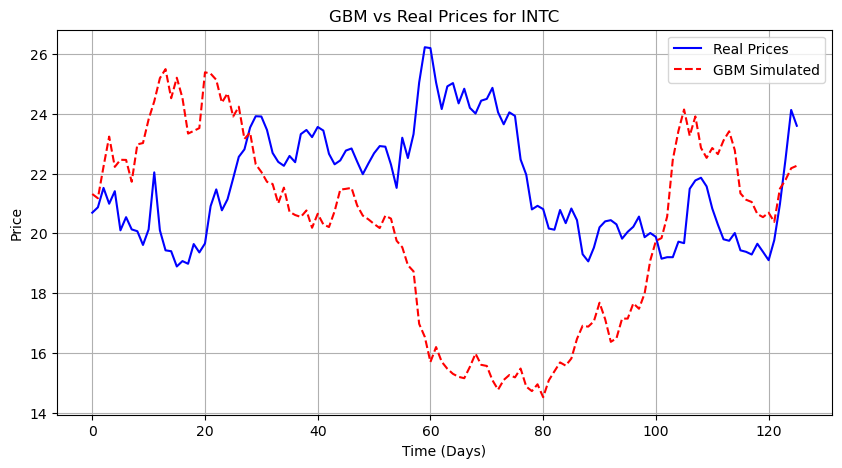

,symbol,expiration_date,option_type,ask_price,ask_size,bid_price,bid_size,open_interest,mid_price,current_price,strike_price,final_price,profitability_likelihood,return_percent,return_if_assignment
3,INTC,2025-02-21,Call,0.48,1,0.47,40,46831,0.475,23.59,25.0,23.661565,83.666667,1.900000,16.700000
5,INTC,2025-02-21,Call,0.44,8,0.40,2,7326,0.420,23.59,25.5,23.587322,89.333333,1.647059,18.117647
8,INTC,2025-02-21,Call,0.26,51,0.24,37,13474,0.250,23.59,27.0,23.573350,98.000000,0.925926,22.037037
9,INTC,2025-02-21,Call,0.38,36,0.36,10,21024,0.370,23.59,26.0,23.709957,93.666667,1.423077,19.500000
15,INTC,2025-02-21,Call,0.34,2,0.25,610,4571,0.295,23.59,26.5,23.493325,98.000000,1.113208,20.735849


In [3]:
contracts = audit_calls(ticker="INTC", expiration_date=datetime(year=2025, month=2, day=21), cost_basis=21.3)

display(contracts)